![image.png](https://i.imgur.com/a3uAqnb.png)

# Variational Autoencoder (VAE) for Anime Portrait Generation
- **Images**: Anime-style portrait images **(64x64, RGB)**
- **Classes**: Various anime characters, but for VAE we **ignore labels**
- **Shape**: `(batch_size, 3, 64, 64)` → 3 RGB channels



## 1️⃣ Dataset Class

In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from datasets import load_dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# Custom Dataset class for Hugging Face dataset
class AnimeDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)
        elif not isinstance(image, Image.Image):
            image = Image.open(image).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, 0  # Return dummy label for compatibility

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64
    transforms.ToTensor(),        # Convert to tensor [0,1]
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1,1]
])

In [4]:
hf_dataset = load_dataset("quindici1515/Anime_style_portrait_dataset", split="train")


In [5]:
train_dataset = AnimeDataset(hf_dataset, transform=transform)


In [8]:
batch_size =  256 # Reduced batch size for larger images
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# Check dataset size
print(f"Training samples: {len(train_dataset)}")

Training samples: 4000


### Let's display some images

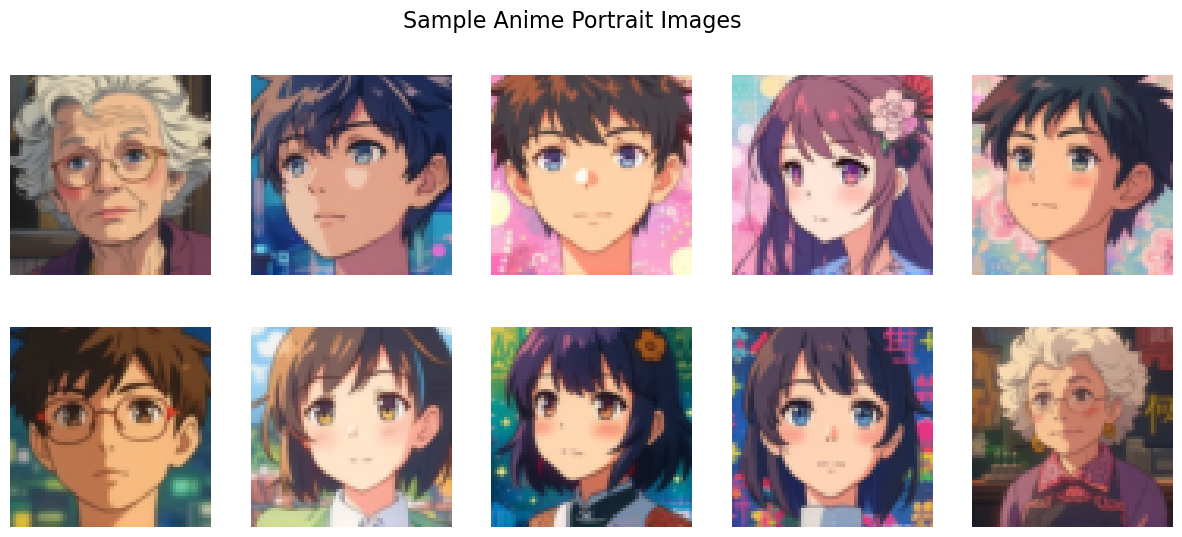

Shape of one image tensor: torch.Size([3, 64, 64])


In [9]:
# Get a batch of training data
data_iter = iter(train_loader)
images, _ = next(data_iter)  # Labels are ignored in VAE

# Denormalize images for display
def denormalize(tensor):
    return (tensor * 0.5) + 0.5  # Convert from [-1,1] to [0,1]

# Show images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    img = denormalize(images[i]).permute(1, 2, 0)  # Change from (C,H,W) to (H,W,C)
    img = torch.clamp(img, 0, 1)  # Ensure values are in [0,1]

    ax.imshow(img.numpy())
    ax.axis("off")

plt.suptitle("Sample Anime Portrait Images", fontsize=16)
plt.show()

# Show shape of one image
print("Shape of one image tensor:", images[0].shape)  # Expected: (3, 64, 64)

## 2️⃣ Model Class

# **📌 Variational Autoencoder (VAE) Model**
A **Variational Autoencoder (VAE)** is a generative model that learns to **encode data into a probabilistic latent space** and **decode it back to reconstruct the original data**.

## **🔹 Key Differences from Standard Autoencoder**
1️⃣ **Probabilistic Encoding**
   - Instead of deterministic encoding, VAE learns **mean (μ) and log-variance (σ²)** of latent distribution
   - Uses **reparameterization trick** to sample from learned distribution

2️⃣ **KL Divergence Loss**
   - Regularizes latent space to follow standard normal distribution
   - Enables smooth interpolation and generation

3️⃣ **Better Generation**
   - Can generate new samples by sampling from prior distribution
   - More structured and meaningful latent space

![VAE Architecture](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*r1R0cxCnErWgE0P4Q-hI0Q.jpeg)

## **📌 Expected Input & Output Shapes**
- **Input:** `(batch_size, 3, 64, 64)`
- **Encoded μ, σ:** `(batch_size, latent_dim)`
- **Decoded Output:** `(batch_size, 3, 64, 64)`

In [10]:
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Enhanced Encoder with more layers
        self.encoder = nn.Sequential(
            # Input: (3, 64, 64)
            nn.Conv2d(3, 32, 4, 2, 1),      # (32, 32, 32)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(32, 32, 3, 1, 1),     # (32, 32, 32) - Additional layer
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 64, 4, 2, 1),     # (64, 16, 16)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 64, 3, 1, 1),     # (64, 16, 16) - Additional layer
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 4, 2, 1),    # (128, 8, 8)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128, 128, 3, 1, 1),   # (128, 8, 8) - Additional layer
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, 4, 2, 1),   # (256, 4, 4)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256, 256, 3, 1, 1),   # (256, 4, 4) - Additional layer
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256, 512, 4, 2, 1),   # (512, 2, 2) - New deeper layer
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Flatten(),                   # (512 * 2 * 2)
        )

        # Enhanced latent space mapping with intermediate layer
        self.fc_intermediate = nn.Sequential(
            nn.Linear(512 * 2 * 2, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2)
        )
        
        self.fc_mu = nn.Linear(1024, latent_dim)
        self.fc_logvar = nn.Linear(1024, latent_dim)

        # Enhanced Decoder
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512 * 2 * 2),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (512, 2, 2)),   # Reshape to (512, 2, 2)

            nn.ConvTranspose2d(512, 256, 4, 2, 1),  # (256, 4, 4)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.ConvTranspose2d(256, 256, 3, 1, 1),  # (256, 4, 4) - Additional layer
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # (128, 8, 8)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 128, 3, 1, 1),  # (128, 8, 8) - Additional layer
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # (64, 16, 16)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 64, 3, 1, 1),    # (64, 16, 16) - Additional layer
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # (32, 32, 32)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 32, 3, 1, 1),    # (32, 32, 32) - Additional layer
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 3, 4, 2, 1),     # (3, 64, 64)
            nn.Tanh()  # Output in [-1, 1] range
        )

    def encode(self, x):
        h = self.encoder(x)
        h = self.fc_intermediate(h)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [11]:
# VAE Loss Function
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + beta * kl_loss, recon_loss, kl_loss

## 3️⃣ Training and Validation Loops

We will train the VAE model to learn meaningful representations of anime portraits.

1️⃣ **Forward Pass** → Encode to μ, σ, sample z, and decode

2️⃣ **Compute Loss** → Reconstruction loss + KL divergence

3️⃣ **Backward Pass** → Update model parameters

In [12]:
# Training Loop for VAE
def train_one_epoch(model, dataloader, optimizer, device, beta=1.0):
    model.train()
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0

    for images, _ in tqdm(dataloader, desc="Training"):
        images = images.to(device)

        # Forward pass
        recon_images, mu, logvar = model(images)

        # Compute VAE loss
        loss, recon_loss, kl_loss = vae_loss(recon_images, images, mu, logvar, beta)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()

    avg_loss = total_loss / len(dataloader.dataset)
    avg_recon_loss = total_recon_loss / len(dataloader.dataset)
    avg_kl_loss = total_kl_loss / len(dataloader.dataset)

    return avg_loss, avg_recon_loss, avg_kl_loss

## 4️⃣ Running Training

VAE uses a combination of reconstruction loss and KL divergence loss to learn meaningful latent representations.


In [14]:
# Initialize the model
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device for Apple Silicon GPU acceleration.")
else:
    device = torch.device("cpu")
    print("MPS device not found, falling back to CPU.")

model = VAE(latent_dim=128).to(device)

# Print model summary
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
num_epochs = 50
beta = 1.0  # Weight for KL divergence

# Store losses for plotting
train_losses = []
recon_losses = []
kl_losses = []

print(f"Training VAE on {device}...")
print(f"Dataset size: {len(train_dataset)}")
print(f"Batch size: {batch_size}")
print("-" * 50)

Using MPS device for Apple Silicon GPU acceleration.
VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(128, 

In [15]:
# device = next(model.parameters()).device
# model.load_state_dict(torch.load('vae_anime_epoch_50.pth', map_location=device))


In [16]:
print(len(kl_losses))
print(len(recon_losses))
print(len(train_losses))

0
0
0


In [17]:
# Training loop
for epoch in range(11,num_epochs):
    train_loss, recon_loss, kl_loss = train_one_epoch(model, train_loader, optimizer, device, beta)

    train_losses.append(train_loss)
    recon_losses.append(recon_loss)
    kl_losses.append(kl_loss)

    print(f"Epoch {epoch+1:2d}/{num_epochs} | "
          f"Total Loss: {train_loss:.4f} | "
          f"Recon: {recon_loss:.4f} | "
          f"KL: {kl_loss:.4f}")

    # Save model checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), f'vae_anime_epoch_{epoch+1}.pth')

print("Training completed!")

Training: 100%|██████████| 16/16 [01:20<00:00,  5.02s/it]


Epoch 12/50 | Total Loss: 30606.3993 | Recon: 4188.9002 | KL: 26417.4985


Training: 100%|██████████| 16/16 [01:11<00:00,  4.46s/it]


Epoch 13/50 | Total Loss: 3293.0807 | Recon: 3257.5413 | KL: 35.5394


Training: 100%|██████████| 16/16 [01:08<00:00,  4.29s/it]


Epoch 14/50 | Total Loss: 3058.1152 | Recon: 3029.3003 | KL: 28.8149


Training: 100%|██████████| 16/16 [01:09<00:00,  4.35s/it]


Epoch 15/50 | Total Loss: 2855.8316 | Recon: 2832.5799 | KL: 23.2517


Training: 100%|██████████| 16/16 [01:08<00:00,  4.29s/it]


Epoch 16/50 | Total Loss: 2649.3424 | Recon: 2627.6613 | KL: 21.6811


Training: 100%|██████████| 16/16 [01:10<00:00,  4.43s/it]


Epoch 17/50 | Total Loss: 2425.8890 | Recon: 2403.6478 | KL: 22.2412


Training: 100%|██████████| 16/16 [01:10<00:00,  4.39s/it]


Epoch 18/50 | Total Loss: 2184.8380 | Recon: 2159.8233 | KL: 25.0147


Training: 100%|██████████| 16/16 [01:09<00:00,  4.31s/it]


Epoch 19/50 | Total Loss: 1976.2505 | Recon: 1946.1047 | KL: 30.1458


Training: 100%|██████████| 16/16 [01:08<00:00,  4.30s/it]


Epoch 20/50 | Total Loss: 1861.1600 | Recon: 1827.7689 | KL: 33.3911


Training: 100%|██████████| 16/16 [01:08<00:00,  4.31s/it]


Epoch 21/50 | Total Loss: 1774.8808 | Recon: 1738.7775 | KL: 36.1033


Training: 100%|██████████| 16/16 [01:09<00:00,  4.36s/it]


Epoch 22/50 | Total Loss: 1713.4976 | Recon: 1675.3932 | KL: 38.1044


Training: 100%|██████████| 16/16 [01:09<00:00,  4.32s/it]


Epoch 23/50 | Total Loss: 1653.4148 | Recon: 1612.5374 | KL: 40.8773


Training: 100%|██████████| 16/16 [01:10<00:00,  4.38s/it]


Epoch 24/50 | Total Loss: 1597.1222 | Recon: 1553.9012 | KL: 43.2210


Training: 100%|██████████| 16/16 [01:10<00:00,  4.40s/it]


Epoch 25/50 | Total Loss: 1548.4697 | Recon: 1502.4126 | KL: 46.0571


Training: 100%|██████████| 16/16 [01:09<00:00,  4.37s/it]


Epoch 26/50 | Total Loss: 1505.4178 | Recon: 1456.5564 | KL: 48.8614


Training: 100%|██████████| 16/16 [01:09<00:00,  4.35s/it]


Epoch 27/50 | Total Loss: 1467.3010 | Recon: 1415.5389 | KL: 51.7622


Training: 100%|██████████| 16/16 [01:09<00:00,  4.37s/it]


Epoch 28/50 | Total Loss: 1441.0029 | Recon: 1386.5921 | KL: 54.4108


Training: 100%|██████████| 16/16 [01:10<00:00,  4.38s/it]


Epoch 29/50 | Total Loss: 1407.2160 | Recon: 1350.6233 | KL: 56.5927


Training: 100%|██████████| 16/16 [01:09<00:00,  4.35s/it]


Epoch 30/50 | Total Loss: 1379.5967 | Recon: 1321.1676 | KL: 58.4291


Training: 100%|██████████| 16/16 [01:09<00:00,  4.36s/it]


Epoch 31/50 | Total Loss: 1362.8019 | Recon: 1302.4913 | KL: 60.3106


Training: 100%|██████████| 16/16 [01:09<00:00,  4.33s/it]


Epoch 32/50 | Total Loss: 1333.0897 | Recon: 1271.2690 | KL: 61.8208


Training: 100%|██████████| 16/16 [01:09<00:00,  4.34s/it]


Epoch 33/50 | Total Loss: 1315.5480 | Recon: 1252.4208 | KL: 63.1272


Training: 100%|██████████| 16/16 [01:10<00:00,  4.40s/it]


Epoch 34/50 | Total Loss: 1298.5652 | Recon: 1233.8584 | KL: 64.7068


Training: 100%|██████████| 16/16 [01:09<00:00,  4.35s/it]


Epoch 35/50 | Total Loss: 1278.3980 | Recon: 1212.3823 | KL: 66.0158


Training: 100%|██████████| 16/16 [01:10<00:00,  4.38s/it]


Epoch 36/50 | Total Loss: 1256.4353 | Recon: 1189.2092 | KL: 67.2261


Training: 100%|██████████| 16/16 [01:10<00:00,  4.43s/it]


Epoch 37/50 | Total Loss: 1237.4836 | Recon: 1169.1104 | KL: 68.3732


Training: 100%|██████████| 16/16 [01:09<00:00,  4.35s/it]


Epoch 38/50 | Total Loss: 1229.4641 | Recon: 1159.8875 | KL: 69.5765


Training: 100%|██████████| 16/16 [01:09<00:00,  4.36s/it]


Epoch 39/50 | Total Loss: 1218.7145 | Recon: 1148.0103 | KL: 70.7042


Training: 100%|██████████| 16/16 [01:10<00:00,  4.38s/it]


Epoch 40/50 | Total Loss: 1204.8375 | Recon: 1133.4115 | KL: 71.4260


Training: 100%|██████████| 16/16 [01:17<00:00,  4.82s/it]


Epoch 41/50 | Total Loss: 1187.8801 | Recon: 1115.5485 | KL: 72.3316


Training: 100%|██████████| 16/16 [01:10<00:00,  4.39s/it]


Epoch 42/50 | Total Loss: 1178.8795 | Recon: 1105.5252 | KL: 73.3543


Training: 100%|██████████| 16/16 [01:10<00:00,  4.42s/it]


Epoch 43/50 | Total Loss: 1172.3635 | Recon: 1098.2542 | KL: 74.1093


Training: 100%|██████████| 16/16 [01:10<00:00,  4.38s/it]


Epoch 44/50 | Total Loss: 1156.1157 | Recon: 1081.6221 | KL: 74.4936


Training: 100%|██████████| 16/16 [01:10<00:00,  4.38s/it]


Epoch 45/50 | Total Loss: 1147.5490 | Recon: 1072.5358 | KL: 75.0132


Training: 100%|██████████| 16/16 [01:10<00:00,  4.38s/it]


Epoch 46/50 | Total Loss: 1140.9912 | Recon: 1064.9476 | KL: 76.0437


Training: 100%|██████████| 16/16 [01:10<00:00,  4.41s/it]


Epoch 47/50 | Total Loss: 1126.7859 | Recon: 1050.1687 | KL: 76.6172


Training: 100%|██████████| 16/16 [01:10<00:00,  4.38s/it]


Epoch 48/50 | Total Loss: 1125.7026 | Recon: 1048.8476 | KL: 76.8550


Training: 100%|██████████| 16/16 [01:10<00:00,  4.38s/it]


Epoch 49/50 | Total Loss: 1115.0337 | Recon: 1037.7637 | KL: 77.2699


Training: 100%|██████████| 16/16 [01:10<00:00,  4.39s/it]

Epoch 50/50 | Total Loss: 1102.2192 | Recon: 1024.6460 | KL: 77.5732
Training completed!


### Plot loss and some predictions

ValueError: x and y must have same first dimension, but have shapes (50,) and (39,)

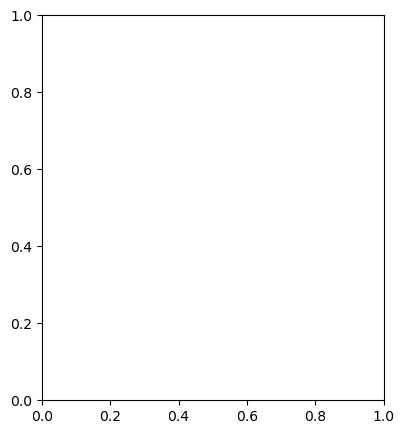

In [20]:
# Plot loss curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Total Loss", marker='o', markersize=3)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Total VAE Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs+1), recon_losses, label="Reconstruction Loss", color='orange', marker='s', markersize=3)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Reconstruction Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs+1), kl_losses, label="KL Divergence", color='green', marker='^', markersize=3)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("KL Divergence Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

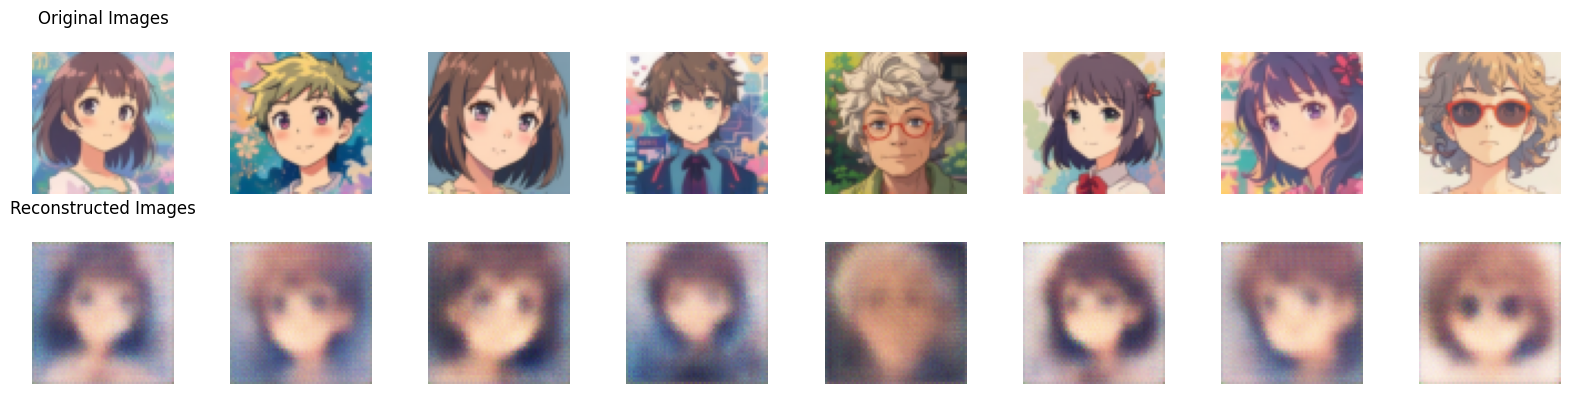

In [24]:
# Function to Display Original vs. Reconstructed Images
def show_original_vs_reconstructed(model, dataloader, device, num_images=8):
    model.eval()

    # Get a batch of images
    images, _ = next(iter(dataloader))
    images = images[:num_images].to(device)

    # Get reconstructed images
    with torch.no_grad():
        reconstructions, _, _ = model(images)

    # Move to CPU and denormalize
    images = denormalize(images.cpu())
    reconstructions = denormalize(reconstructions.cpu())

    # Plot original vs reconstructed images
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))

    for i in range(num_images):
        # Original images (Top row)
        img_orig = torch.clamp(images[i].permute(1, 2, 0), 0, 1)
        axes[0, i].imshow(img_orig.numpy())
        axes[0, i].axis("off")

        # Reconstructed images (Bottom row)
        img_recon = torch.clamp(reconstructions[i].permute(1, 2, 0), 0, 1)
        axes[1, i].imshow(img_recon.numpy())
        axes[1, i].axis("off")

    axes[0, 0].set_title("Original Images", fontsize=12, pad=20)
    axes[1, 0].set_title("Reconstructed Images", fontsize=12, pad=20)
    plt.tight_layout()
    plt.show()

# Display Results
show_original_vs_reconstructed(model, train_loader, device)

Let's generate some images:

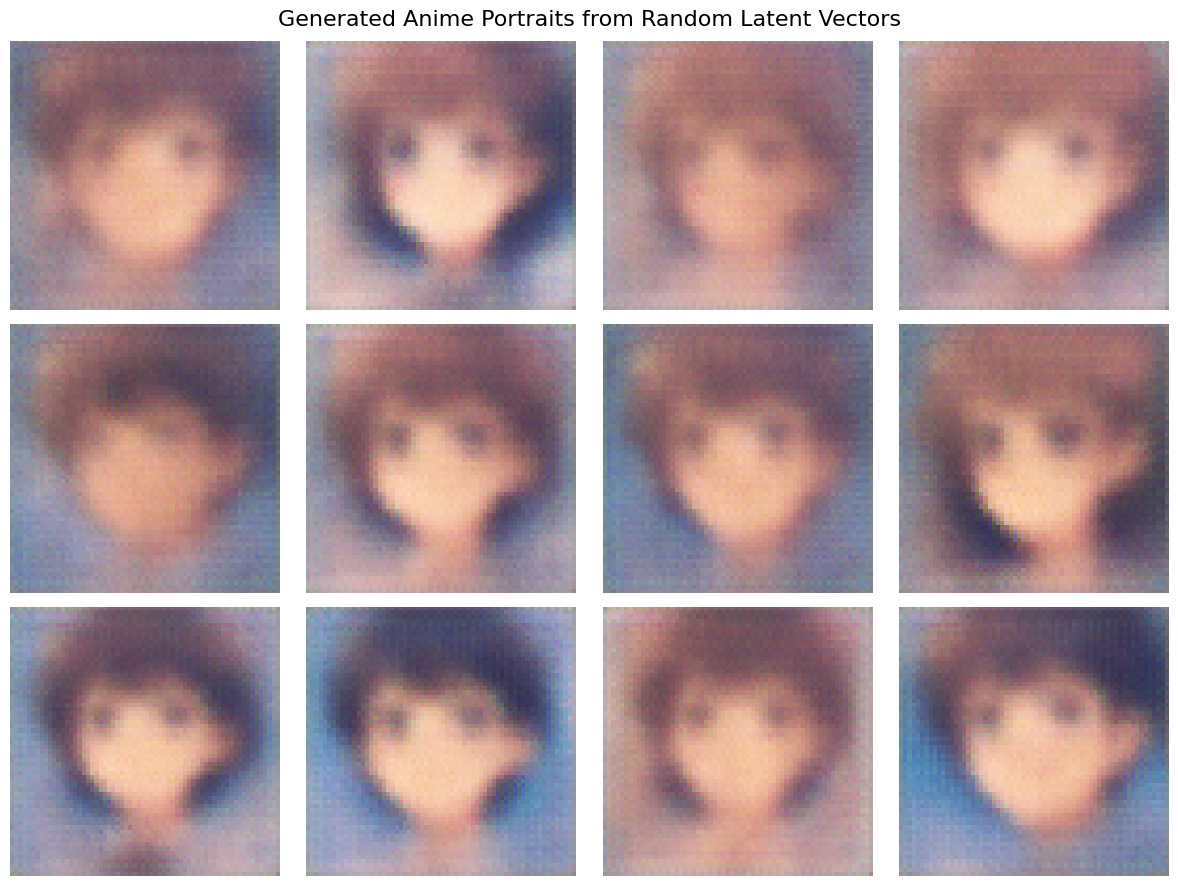

In [25]:
import matplotlib.pyplot as plt

# Function to Generate New Images
def generate_images(model, device, num_images=12, latent_dim=128):
    model.eval()

    # Sample from standard normal distribution
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim).to(device)
        generated_images = model.decode(z).cpu()

    # Denormalize images
    generated_images = denormalize(generated_images)
    generated_images = torch.clamp(generated_images, 0, 1)

    # Plot generated images
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    for i, ax in enumerate(axes.flat):
        img = generated_images[i].permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.axis("off")

    plt.suptitle("Generated Anime Portraits from Random Latent Vectors", fontsize=16)
    plt.tight_layout()
    plt.show()

# Generate & Display New Anime Images
generate_images(model, device, num_images=12, latent_dim=128)

The quality of generated images heavily depends on the model architecture, latent dimension size, dataset complexity, and training duration. These might not look perfect after a short training run.

## **🔹 Exercise: Effect of Latent Dimension and Beta Parameter**

### **📝 Tasks**
1. **Latent Dimension**: Try different `latent_dim` values (32, 64, 256, 512) - observe the trade-off between compression and quality
2. **Beta Parameter**: Experiment with different `beta` values (0.1, 0.5, 2.0, 10.0) - controls the balance between reconstruction and regularization
3. **Architecture**: Try adding/removing layers or changing filter sizes

### **🎯 Key Observations to Make**
- **Lower latent_dim**: More compression but potentially blurrier results
- **Higher beta**: More regularized latent space but potentially worse reconstruction
- **Lower beta**: Better reconstruction but potentially less structured latent space

### Contributed by: Ali Habibullah. (Updated from Mohamed Eltayeb's original MNIST Autoencoder - I just used Claude to do it 🌚)